# Assignment 5: Monte Carlo Interactions (Physics 420)

Write a simple Monte Carlo to calculate diffusion of a single argon atom in argon gas, taking the origin as the position of the atom at time t=0.  Assume the gas is at standard temperature and pressure (ie.  one mole is 22.7 liters at 100 kPa and 273 K).  Throw the energy of gas molecules according to the Maxwell Boltzmann distribution(below).  The mean free path for argon is 6.2e-6 cm at 273 K.  Treat the atoms as "hard spheres" with radius 3.67e-8 cm.  Calculate the collisions in the center of mass. For hard spheres the angle of incidence=angle of reflection, where the angle is measured between the velocity and the line from the center of the sphere to the point of impact.   

Calculate:
1.  The number of collisions/second.  (Simulate a million collisions and find the time to calculate this).  
2.  Plot the distance from the origin the atom travels as a function of time.
3.  The energy distribution of the particle as it bounces. 
4.  Redo the calculation for as many particles and as long a time as is practical on your computer.  (Limit your calculation times to a few hours).  

From Wikipedia, we find Maxwell Boltmann distribution is defined as:
Assuming the system of interest contains a large number of particles, the fraction of the particles within an infinitesimal element of three-dimensional velocity space, ${\displaystyle d^{3}v},$ centered on a velocity vector of magnitude ${\displaystyle v}$, is ${\displaystyle f(v)d^{3}v}$, in which

$${\displaystyle f(v)~\mathrm {d} ^{3}v=\left({\frac {m}{2\pi kT}}\right)^{3/2}\,e^{-{\frac {mv^{2}}{2kT}}}~\mathrm {d} ^{3}v,}$$
where ${\displaystyle m} $ is the particle mass and ${\displaystyle kT}$ is the product of Boltzmann's constant and thermodynamic temperature.


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import matplotlib as mpl
from pprint import pprint
import pandas as pd


mpl.rc('figure',dpi=250)
mpl.rc('text',usetex=True)

m = (39.948/(6.022*10**23))/1000 #one argon atom
T = 273.15
k = 1.38064852*10**-23
argonRadius = 3.67e-8/100

np.random.seed(3)

(array([1.15621175e-05, 4.23944309e-05, 8.09348226e-05, 2.04264076e-04,
        4.39360465e-04, 6.28208385e-04, 1.04059058e-03, 1.32964351e-03,
        1.54932375e-03, 1.61098837e-03, 1.54161567e-03, 1.20631426e-03,
        8.86429009e-04, 4.54776622e-04, 2.96761016e-04, 1.50307528e-04,
        5.01025092e-05, 2.69782742e-05, 7.70807834e-06, 7.70807834e-06]),
 array([-803.8009408 , -717.34041338, -630.87988596, -544.41935855,
        -457.95883113, -371.49830371, -285.03777629, -198.57724888,
        -112.11672146,  -25.65619404,   60.80433338,  147.26486079,
         233.72538821,  320.18591563,  406.64644305,  493.10697046,
         579.56749788,  666.0280253 ,  752.48855272,  838.94908013,
         925.40960755]),
 <a list of 20 Patch objects>)

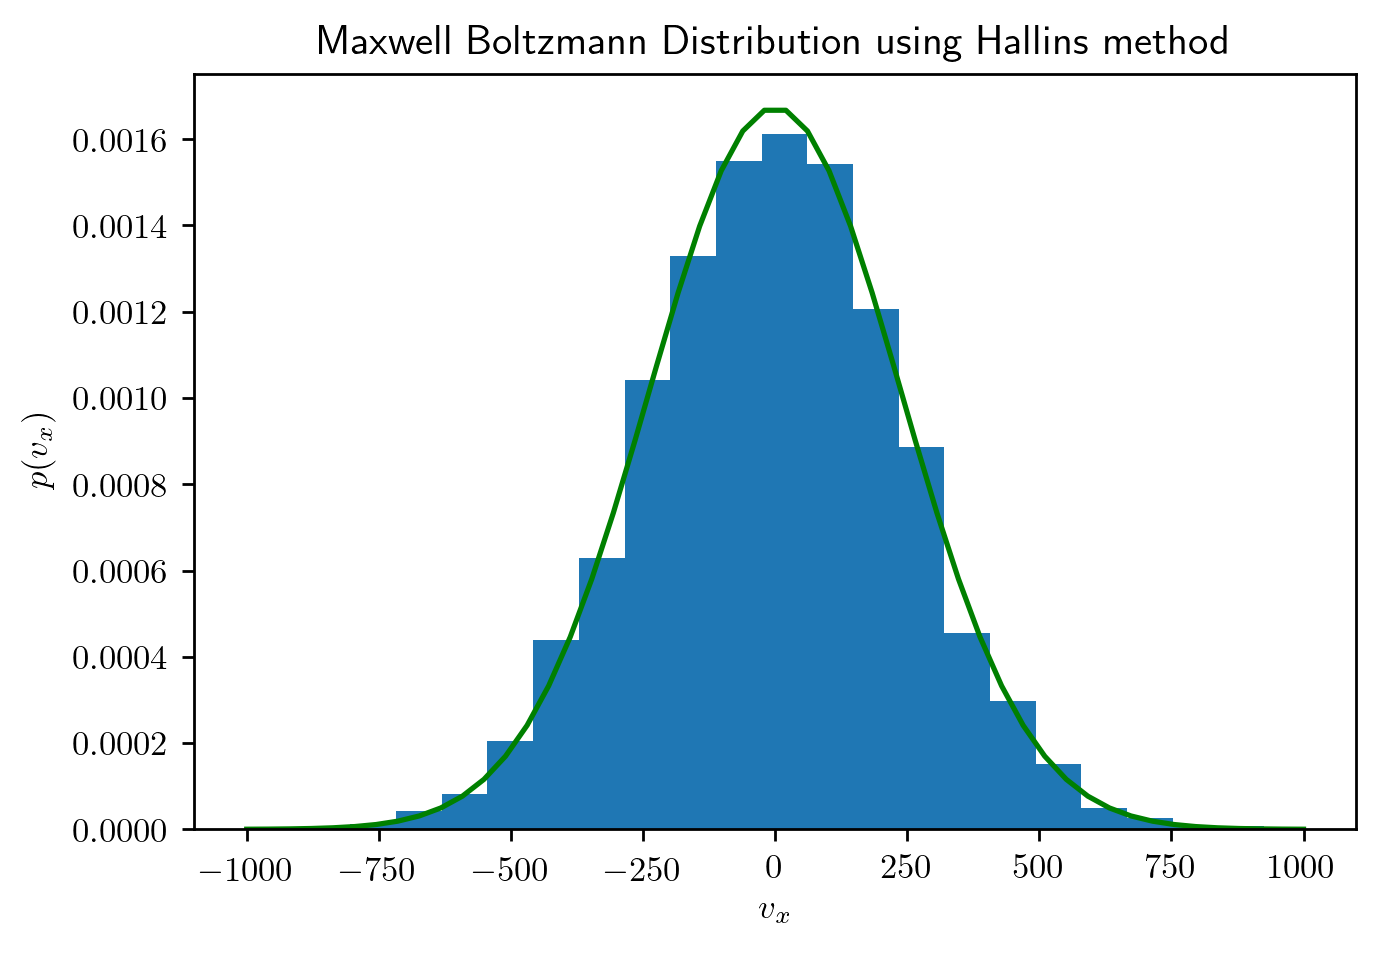

In [35]:
# I have coded Hallin's way of drawing samples using Monte Carlo, 
# but it is actually just more convienient to use np.random.normal and set the variance and mean
# to fit the maxwell Boltzmann distribution. This is due to the fact that a maxwell boltzmann distribution is just
# a special case of a gaussian. As a result, this code is only for show.

v = np.linspace(-1000, 1000)

def maxwell_boltzmann(v):
    '''Maxwell Boltzmann in 1-D'''    
    return (m/(2*np.pi*k*T))**(1/2)*np.exp(-m*v**2/(2*k*T))

normalization_factor = quad(lambda v: maxwell_boltzmann(v), -1000, 1000)[0]
normalization_factor

def maxwell_boltzmann_normalized(v):
    return maxwell_boltzmann(v)/normalization_factor

def generate_samples(N=10000):
    v_max = max(maxwell_boltzmann_normalized(v))
    
    x_rand = np.random.uniform(-1000, 1000, size=N)
    y_rand = np.random.uniform(0, v_max, size=N)
    
    samples = x_rand[y_rand < maxwell_boltzmann_normalized(x_rand)]
    
    return samples.reshape(len(samples), 1)

x = generate_samples()


plt.plot(v, maxwell_boltzmann_normalized(v), c='g')
plt.xlabel('$v_x$')
plt.ylabel('$p(v_x)$')
plt.title('Maxwell Boltzmann Distribution using Hallins method')

plt.hist(x, bins=20, density=True)

In [36]:
# Here we draw the samples from a Gaussian, which is fit to the Maxwell Boltzmann.

velocities = np.empty((50000, 3), dtype='float64')
velocities = np.random.normal(0, scale=np.sqrt((k*T)/m), size=(50000, 3))

velocity_x = velocities[:, 0]
velocity_y = velocities[:, 1]
velocity_z = velocities[:, 2]

Text(0.5, 1.0, 'Maxwell Boltzmann Distribution using scipy')

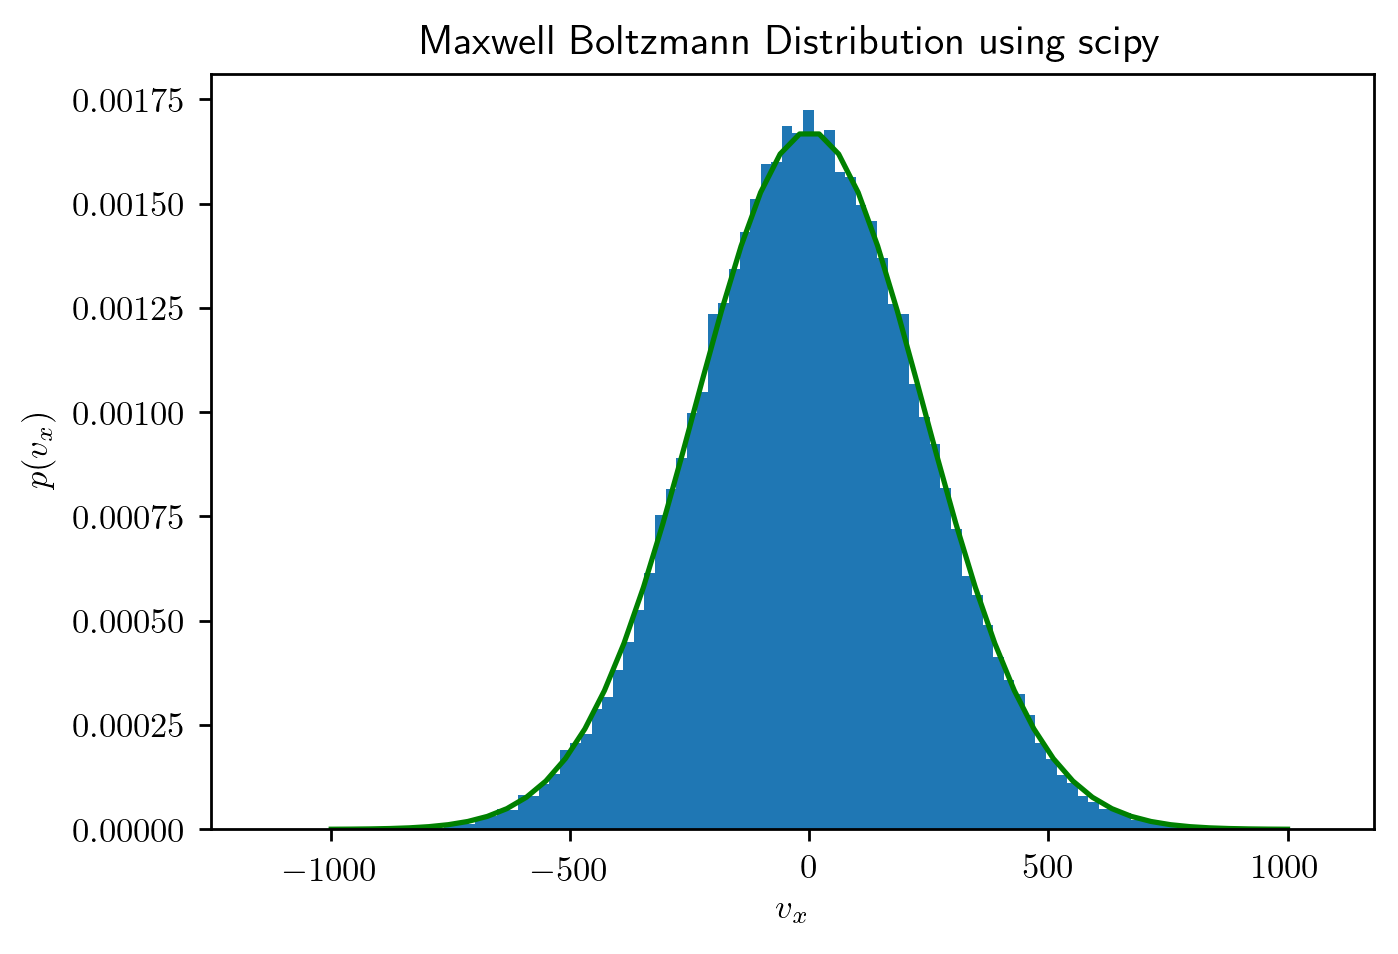

In [37]:
plt.plot(v, maxwell_boltzmann_normalized(v), c='g')
plt.hist(velocity_x, bins=100, density=True)
plt.xlabel('$v_x$')
plt.ylabel('$p(v_x)$')
plt.title('Maxwell Boltzmann Distribution using scipy')

(-2e-07, 2e-07)

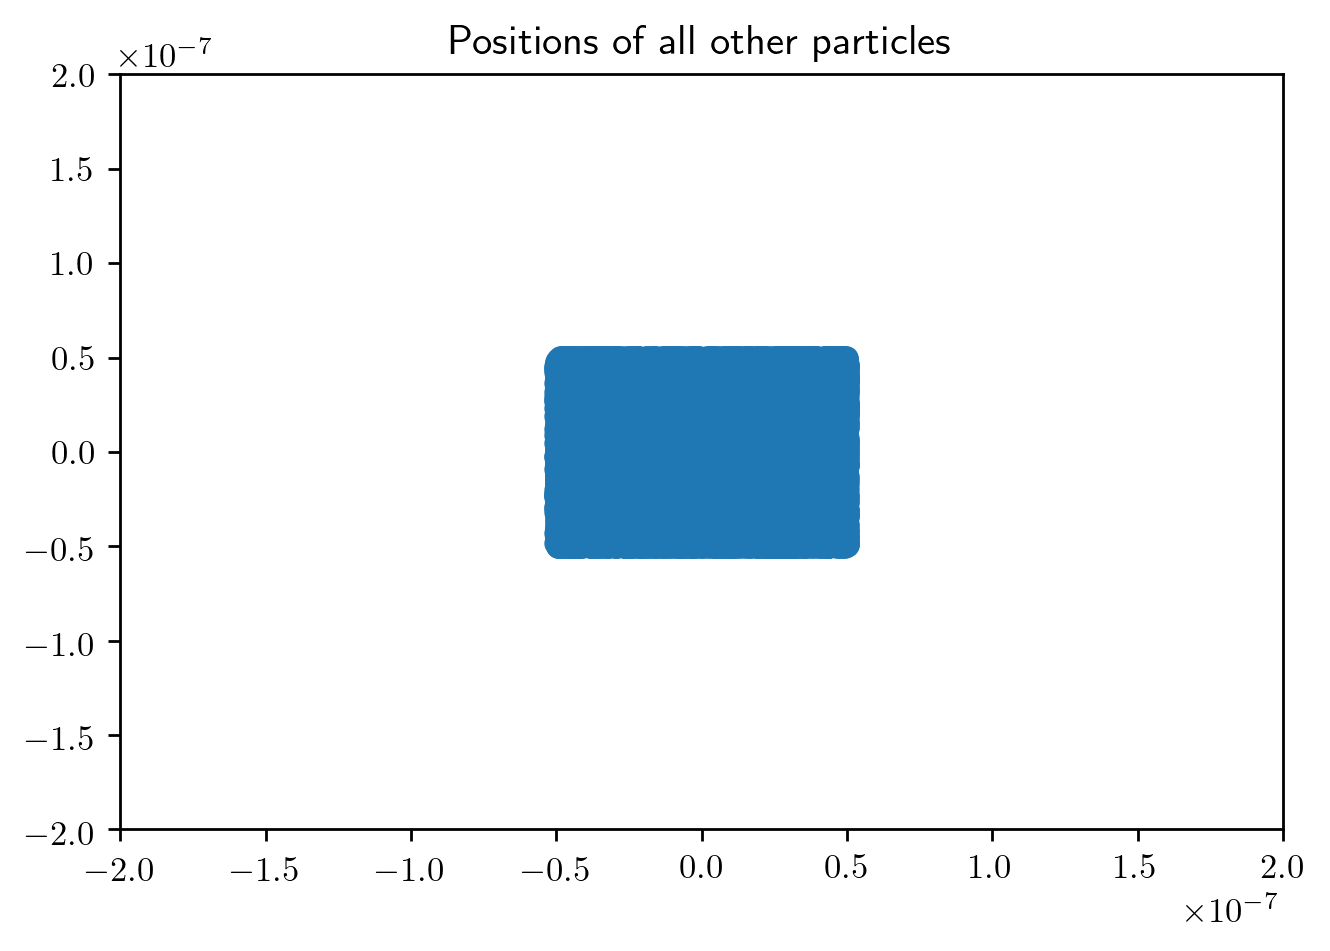

In [38]:
wallRadius = 0.5*1e-7

positions = np.empty((50000, 3), dtype='float64')
positions = np.random.uniform(-wallRadius, wallRadius ,size=(50000, 3))
positions

plt.scatter(positions[:, 0], positions[:, 1])
plt.title('Positions of all other particles')
plt.xlim(-4*wallRadius, 4*wallRadius)
plt.ylim(-4*wallRadius, 4*wallRadius)



In [39]:
class Argon:
    def __init__(self, position, velocity):
        self.position = position
        self.velocity = velocity
        self.radius = argonRadius
        self.dist = 0
        self.collisions = 0
        self.dx = 0
        self.energy = 0
        
    def update_dt(self):
        self.dist += np.linalg.norm(self.velocity*dt)
        self.position += self.velocity*dt
        self.dx = np.linalg.norm(self.velocity*dt)
         
    def check_collision(self, atom):
        if np.linalg.norm(self.position - atom.position) < 2*self.radius:
            #probably wrong, but a good first approximation
            #wrong cause does not take incidence, reflection into account
            self.velocity = np.random.normal(0, scale=np.sqrt((k*T)/m), size=(3))
            print('collide')
            self.collisions += 1
            
    def check_bounds(self):
        for i, pos in enumerate(self.position):
            if np.abs(pos) > wallRadius: 
                print(pos, wallRadius)
                self.velocity[i] *= -1
                print('out of bounds', self.position, self.velocity)
    
    def force_collision(self):
        if self.dist >= meanFreePath:
            self.velocity = np.random.normal(0, scale=np.sqrt((k*T)/m), size=3)
            print('forced collide')
            self.dist = 0
            self.collisions += 1
            
    def compute_energy(self):
        self.energy = (1/2)*(self.velocity.T @ self.velocity)

In [40]:
mainArgon = Argon(np.array([0,0,0], dtype='float64') , velocities[0])
dt = 1e-12
meanFreePath = 6.2e-6/100

atoms = []

data = []
for i in range(1, 50000):
    atoms.append(Argon(positions[i], velocities[i]))
    
def simulate():
    for atom in atoms:
        mainArgon.check_collision(atom)
    mainArgon.compute_energy()
    
    #mainArgon.force_collision()
    
    mainArgondata = {'pos':mainArgon.position.copy(), 'vel': mainArgon.velocity.copy(), 't':t, 'change_pos':mainArgon.dx, 'energy':mainArgon.energy, 'collisions':mainArgon.collisions}
    pprint(mainArgondata)
    data.append(mainArgondata)
    
    mainArgon.check_bounds()
    mainArgon.update_dt()
    
path = []
for t in np.arange(0, dt*1000, dt):
    path.append(mainArgon.position.copy())
    simulate()


{'change_pos': 0,
 'collisions': 0,
 'energy': 102486.04150987191,
 'pos': array([0., 0., 0.]),
 't': 0.0,
 'vel': array([  40.22192538, -114.49243031, -436.17171291])}
{'change_pos': 4.527384267098871e-10,
 'collisions': 0,
 'energy': 102486.04150987191,
 'pos': array([ 4.02219254e-11, -1.14492430e-10, -4.36171713e-10]),
 't': 1e-12,
 'vel': array([  40.22192538, -114.49243031, -436.17171291])}
{'change_pos': 4.527384267098871e-10,
 'collisions': 0,
 'energy': 102486.04150987191,
 'pos': array([ 8.04438508e-11, -2.28984861e-10, -8.72343426e-10]),
 't': 2e-12,
 'vel': array([  40.22192538, -114.49243031, -436.17171291])}
{'change_pos': 4.527384267098871e-10,
 'collisions': 0,
 'energy': 102486.04150987191,
 'pos': array([ 1.20665776e-10, -3.43477291e-10, -1.30851514e-09]),
 't': 3e-12,
 'vel': array([  40.22192538, -114.49243031, -436.17171291])}
{'change_pos': 4.527384267098871e-10,
 'collisions': 0,
 'energy': 102486.04150987191,
 'pos': array([ 1.60887702e-10, -4.57969721e-10, -1.74

{'change_pos': 5.327267305387043e-10,
 'collisions': 8,
 'energy': 141898.88471522857,
 'pos': array([-7.65794411e-09, -5.45082095e-09, -2.77653045e-09]),
 't': 3.6e-11,
 'vel': array([-456.17868146, -233.23465465,  145.94648294])}
{'change_pos': 5.327267305387043e-10,
 'collisions': 8,
 'energy': 141898.88471522857,
 'pos': array([-8.11412279e-09, -5.68405560e-09, -2.63058397e-09]),
 't': 3.7e-11,
 'vel': array([-456.17868146, -233.23465465,  145.94648294])}
{'change_pos': 5.327267305387043e-10,
 'collisions': 8,
 'energy': 141898.88471522857,
 'pos': array([-8.57030147e-09, -5.91729026e-09, -2.48463748e-09]),
 't': 3.8e-11,
 'vel': array([-456.17868146, -233.23465465,  145.94648294])}
{'change_pos': 5.327267305387043e-10,
 'collisions': 8,
 'energy': 141898.88471522857,
 'pos': array([-9.02648015e-09, -6.15052491e-09, -2.33869100e-09]),
 't': 3.9e-11,
 'vel': array([-456.17868146, -233.23465465,  145.94648294])}
{'change_pos': 5.327267305387043e-10,
 'collisions': 8,
 'energy': 14189

{'change_pos': 5.001263933088032e-10,
 'collisions': 19,
 'energy': 125063.20464203584,
 'pos': array([-5.25988817e-09, -1.02395618e-08, -2.24990473e-09]),
 't': 7.1e-11,
 'vel': array([-242.96645132, -375.70882533,  223.46496679])}
{'change_pos': 5.001263933088032e-10,
 'collisions': 19,
 'energy': 125063.20464203584,
 'pos': array([-5.50285462e-09, -1.06152706e-08, -2.02643976e-09]),
 't': 7.2e-11,
 'vel': array([-242.96645132, -375.70882533,  223.46496679])}
{'change_pos': 5.001263933088032e-10,
 'collisions': 19,
 'energy': 125063.20464203584,
 'pos': array([-5.74582107e-09, -1.09909794e-08, -1.80297480e-09]),
 't': 7.299999999999999e-11,
 'vel': array([-242.96645132, -375.70882533,  223.46496679])}
{'change_pos': 5.001263933088032e-10,
 'collisions': 19,
 'energy': 125063.20464203584,
 'pos': array([-5.98878752e-09, -1.13666883e-08, -1.57950983e-09]),
 't': 7.4e-11,
 'vel': array([-242.96645132, -375.70882533,  223.46496679])}
{'change_pos': 5.001263933088032e-10,
 'collisions': 1

{'change_pos': 4.109399304468679e-10,
 'collisions': 31,
 'energy': 84435.81321783832,
 'pos': array([-1.00143018e-08, -1.38275854e-08, -5.16083421e-09]),
 't': 1.06e-10,
 'vel': array([-128.42572879,   79.69319276, -382.13538654])}
{'change_pos': 4.109399304468679e-10,
 'collisions': 31,
 'energy': 84435.81321783832,
 'pos': array([-1.01427275e-08, -1.37478923e-08, -5.54296960e-09]),
 't': 1.0699999999999999e-10,
 'vel': array([-128.42572879,   79.69319276, -382.13538654])}
{'change_pos': 4.109399304468679e-10,
 'collisions': 31,
 'energy': 84435.81321783832,
 'pos': array([-1.02711532e-08, -1.36681991e-08, -5.92510498e-09]),
 't': 1.08e-10,
 'vel': array([-128.42572879,   79.69319276, -382.13538654])}
{'change_pos': 4.109399304468679e-10,
 'collisions': 31,
 'energy': 84435.81321783832,
 'pos': array([-1.03995790e-08, -1.35885059e-08, -6.30724037e-09]),
 't': 1.09e-10,
 'vel': array([-128.42572879,   79.69319276, -382.13538654])}
{'change_pos': 4.109399304468679e-10,
 'collisions': 3

{'change_pos': 2.8056351051565714e-10,
 'collisions': 34,
 'energy': 39357.94171643463,
 'pos': array([-1.32191922e-08, -1.04411709e-08, -1.68194618e-08]),
 't': 1.41e-10,
 'vel': array([208.23483037, 171.27986873,  77.57155032])}
{'change_pos': 2.8056351051565714e-10,
 'collisions': 34,
 'energy': 39357.94171643463,
 'pos': array([-1.30109574e-08, -1.02698910e-08, -1.67418902e-08]),
 't': 1.42e-10,
 'vel': array([208.23483037, 171.27986873,  77.57155032])}
{'change_pos': 2.8056351051565714e-10,
 'collisions': 34,
 'energy': 39357.94171643463,
 'pos': array([-1.28027226e-08, -1.00986112e-08, -1.66643187e-08]),
 't': 1.43e-10,
 'vel': array([208.23483037, 171.27986873,  77.57155032])}
{'change_pos': 2.8056351051565714e-10,
 'collisions': 34,
 'energy': 39357.94171643463,
 'pos': array([-1.25944877e-08, -9.92733128e-09, -1.65867471e-08]),
 't': 1.44e-10,
 'vel': array([208.23483037, 171.27986873,  77.57155032])}
{'change_pos': 2.8056351051565714e-10,
 'collisions': 34,
 'energy': 39357.9

{'change_pos': 4.977870699834114e-10,
 'collisions': 35,
 'energy': 123895.98352133484,
 'pos': array([-1.01812433e-08, -1.09672129e-08, -1.81736640e-08]),
 't': 1.77e-10,
 'vel': array([-163.30725048, -386.39656861, -267.9932849 ])}
{'change_pos': 4.977870699834114e-10,
 'collisions': 35,
 'energy': 123895.98352133484,
 'pos': array([-1.03445505e-08, -1.13536094e-08, -1.84416573e-08]),
 't': 1.78e-10,
 'vel': array([-163.30725048, -386.39656861, -267.9932849 ])}
{'change_pos': 4.977870699834114e-10,
 'collisions': 35,
 'energy': 123895.98352133484,
 'pos': array([-1.05078578e-08, -1.17400060e-08, -1.87096506e-08]),
 't': 1.79e-10,
 'vel': array([-163.30725048, -386.39656861, -267.9932849 ])}
{'change_pos': 4.977870699834114e-10,
 'collisions': 35,
 'energy': 123895.98352133484,
 'pos': array([-1.06711650e-08, -1.21264026e-08, -1.89776438e-08]),
 't': 1.8e-10,
 'vel': array([-163.30725048, -386.39656861, -267.9932849 ])}
{'change_pos': 4.977870699834114e-10,
 'collisions': 35,
 'energy

{'change_pos': 6.355757923695122e-10,
 'collisions': 42,
 'energy': 201978.29392306658,
 'pos': array([-1.80115943e-08, -1.87472489e-08, -2.13557761e-08]),
 't': 2.12e-10,
 'vel': array([-547.60150924,   96.2861644 ,  307.92555832])}
{'change_pos': 6.355757923695122e-10,
 'collisions': 42,
 'energy': 201978.29392306658,
 'pos': array([-1.85591958e-08, -1.86509627e-08, -2.10478506e-08]),
 't': 2.13e-10,
 'vel': array([-547.60150924,   96.2861644 ,  307.92555832])}
{'change_pos': 6.355757923695122e-10,
 'collisions': 42,
 'energy': 201978.29392306658,
 'pos': array([-1.91067974e-08, -1.85546766e-08, -2.07399250e-08]),
 't': 2.1399999999999998e-10,
 'vel': array([-547.60150924,   96.2861644 ,  307.92555832])}
{'change_pos': 6.355757923695122e-10,
 'collisions': 42,
 'energy': 201978.29392306658,
 'pos': array([-1.96543989e-08, -1.84583904e-08, -2.04319995e-08]),
 't': 2.15e-10,
 'vel': array([-547.60150924,   96.2861644 ,  307.92555832])}
{'change_pos': 6.355757923695122e-10,
 'collisions

{'change_pos': 2.105367977315672e-10,
 'collisions': 45,
 'energy': 22162.871599531423,
 'pos': array([-3.57008776e-08, -1.59289837e-08, -1.24484699e-08]),
 't': 2.47e-10,
 'vel': array([  51.2890785 , -161.54209769, -124.89725497])}
{'change_pos': 2.105367977315672e-10,
 'collisions': 45,
 'energy': 22162.871599531423,
 'pos': array([-3.56495885e-08, -1.60905258e-08, -1.25733671e-08]),
 't': 2.4799999999999997e-10,
 'vel': array([  51.2890785 , -161.54209769, -124.89725497])}
{'change_pos': 2.105367977315672e-10,
 'collisions': 45,
 'energy': 22162.871599531423,
 'pos': array([-3.55982994e-08, -1.62520679e-08, -1.26982644e-08]),
 't': 2.49e-10,
 'vel': array([  51.2890785 , -161.54209769, -124.89725497])}
{'change_pos': 2.105367977315672e-10,
 'collisions': 45,
 'energy': 22162.871599531423,
 'pos': array([-3.55470103e-08, -1.64136100e-08, -1.28231616e-08]),
 't': 2.5e-10,
 'vel': array([  51.2890785 , -161.54209769, -124.89725497])}
{'change_pos': 2.105367977315672e-10,
 'collisions'

{'change_pos': 6.174788088075948e-10,
 'collisions': 60,
 'energy': 190640.03966322308,
 'pos': array([-3.31429408e-08, -1.71091092e-08, -1.27943076e-08]),
 't': 2.82e-10,
 'vel': array([227.53235034, 407.96207702, 403.82676062])}
{'change_pos': 6.174788088075948e-10,
 'collisions': 60,
 'energy': 190640.03966322308,
 'pos': array([-3.29154085e-08, -1.67011472e-08, -1.23904808e-08]),
 't': 2.83e-10,
 'vel': array([227.53235034, 407.96207702, 403.82676062])}
{'change_pos': 6.174788088075948e-10,
 'collisions': 60,
 'energy': 190640.03966322308,
 'pos': array([-3.26878761e-08, -1.62931851e-08, -1.19866541e-08]),
 't': 2.84e-10,
 'vel': array([227.53235034, 407.96207702, 403.82676062])}
{'change_pos': 6.174788088075948e-10,
 'collisions': 60,
 'energy': 190640.03966322308,
 'pos': array([-3.24603438e-08, -1.58852230e-08, -1.15828273e-08]),
 't': 2.85e-10,
 'vel': array([227.53235034, 407.96207702, 403.82676062])}
{'change_pos': 6.174788088075948e-10,
 'collisions': 60,
 'energy': 190640.0

{'change_pos': 2.580705147397791e-10,
 'collisions': 67,
 'energy': 33300.195289027266,
 'pos': array([-3.23580393e-08, -1.15335987e-08, -5.79312732e-09]),
 't': 3.17e-10,
 'vel': array([-244.00801819,  -58.99443899,   59.83421936])}
{'change_pos': 2.580705147397791e-10,
 'collisions': 67,
 'energy': 33300.195289027266,
 'pos': array([-3.26020474e-08, -1.15925931e-08, -5.73329310e-09]),
 't': 3.18e-10,
 'vel': array([-244.00801819,  -58.99443899,   59.83421936])}
{'change_pos': 2.580705147397791e-10,
 'collisions': 67,
 'energy': 33300.195289027266,
 'pos': array([-3.28460554e-08, -1.16515876e-08, -5.67345888e-09]),
 't': 3.19e-10,
 'vel': array([-244.00801819,  -58.99443899,   59.83421936])}
{'change_pos': 2.580705147397791e-10,
 'collisions': 67,
 'energy': 33300.195289027266,
 'pos': array([-3.30900634e-08, -1.17105820e-08, -5.61362466e-09]),
 't': 3.2e-10,
 'vel': array([-244.00801819,  -58.99443899,   59.83421936])}
{'change_pos': 2.580705147397791e-10,
 'collisions': 67,
 'energy

{'change_pos': 2.580705147397791e-10,
 'collisions': 67,
 'energy': 33300.195289027266,
 'pos': array([-4.08983200e-08, -1.35984041e-08, -3.69892964e-09]),
 't': 3.5199999999999997e-10,
 'vel': array([-244.00801819,  -58.99443899,   59.83421936])}
{'change_pos': 2.580705147397791e-10,
 'collisions': 67,
 'energy': 33300.195289027266,
 'pos': array([-4.11423280e-08, -1.36573985e-08, -3.63909542e-09]),
 't': 3.5299999999999997e-10,
 'vel': array([-244.00801819,  -58.99443899,   59.83421936])}
{'change_pos': 2.580705147397791e-10,
 'collisions': 67,
 'energy': 33300.195289027266,
 'pos': array([-4.13863360e-08, -1.37163929e-08, -3.57926120e-09]),
 't': 3.54e-10,
 'vel': array([-244.00801819,  -58.99443899,   59.83421936])}
{'change_pos': 2.580705147397791e-10,
 'collisions': 67,
 'energy': 33300.195289027266,
 'pos': array([-4.16303440e-08, -1.37753874e-08, -3.51942698e-09]),
 't': 3.55e-10,
 'vel': array([-244.00801819,  -58.99443899,   59.83421936])}
{'change_pos': 2.580705147397791e-10

{'change_pos': 1.8974005342339638e-10,
 'collisions': 74,
 'energy': 18000.64393655666,
 'pos': array([-4.45322882e-08, -1.48005459e-08, -1.91682636e-09]),
 't': 3.87e-10,
 'vel': array([183.87619857,  40.25125573,  23.88865601])}
{'change_pos': 1.8974005342339638e-10,
 'collisions': 74,
 'energy': 18000.64393655666,
 'pos': array([-4.43484120e-08, -1.47602946e-08, -1.89293770e-09]),
 't': 3.88e-10,
 'vel': array([183.87619857,  40.25125573,  23.88865601])}
{'change_pos': 1.8974005342339638e-10,
 'collisions': 74,
 'energy': 18000.64393655666,
 'pos': array([-4.41645358e-08, -1.47200434e-08, -1.86904905e-09]),
 't': 3.89e-10,
 'vel': array([183.87619857,  40.25125573,  23.88865601])}
{'change_pos': 1.8974005342339638e-10,
 'collisions': 74,
 'energy': 18000.64393655666,
 'pos': array([-4.39806596e-08, -1.46797921e-08, -1.84516039e-09]),
 't': 3.9e-10,
 'vel': array([183.87619857,  40.25125573,  23.88865601])}
{'change_pos': 1.8974005342339638e-10,
 'collisions': 74,
 'energy': 18000.64

{'change_pos': 7.928996667917229e-10,
 'collisions': 75,
 'energy': 314344.9407992126,
 'pos': array([-4.15964638e-08, -2.08275232e-08, -4.60093500e-09]),
 't': 4.22e-10,
 'vel': array([ 729.31002517, -283.04314895, -129.16402213])}
{'change_pos': 7.928996667917229e-10,
 'collisions': 75,
 'energy': 314344.9407992126,
 'pos': array([-4.08671537e-08, -2.11105664e-08, -4.73009902e-09]),
 't': 4.23e-10,
 'vel': array([ 729.31002517, -283.04314895, -129.16402213])}
{'change_pos': 7.928996667917229e-10,
 'collisions': 75,
 'energy': 314344.9407992126,
 'pos': array([-4.01378437e-08, -2.13936095e-08, -4.85926304e-09]),
 't': 4.24e-10,
 'vel': array([ 729.31002517, -283.04314895, -129.16402213])}
{'change_pos': 7.928996667917229e-10,
 'collisions': 75,
 'energy': 314344.9407992126,
 'pos': array([-3.94085337e-08, -2.16766527e-08, -4.98842706e-09]),
 't': 4.25e-10,
 'vel': array([ 729.31002517, -283.04314895, -129.16402213])}
{'change_pos': 7.928996667917229e-10,
 'collisions': 75,
 'energy': 

{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.01559081e-08, -2.75149999e-08, -3.97190126e-09]),
 't': 4.5699999999999997e-10,
 'vel': array([-50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.02068551e-08, -2.74740265e-08, -4.00036749e-09]),
 't': 4.5799999999999997e-10,
 'vel': array([-50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.02578020e-08, -2.74330532e-08, -4.02883373e-09]),
 't': 4.5899999999999997e-10,
 'vel': array([-50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.03087490e-08, -2.73920798e-08, -4.05729997e-09]),
 't': 4.6e-10,
 'vel': array([-50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'col

{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.19899990e-08, -2.60399589e-08, -4.99668581e-09]),
 't': 4.93e-10,
 'vel': array([-50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.20409460e-08, -2.59989855e-08, -5.02515205e-09]),
 't': 4.94e-10,
 'vel': array([-50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.20918930e-08, -2.59580121e-08, -5.05361829e-09]),
 't': 4.949999999999999e-10,
 'vel': array([-50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.21428399e-08, -2.59170388e-08, -5.08208452e-09]),
 't': 4.959999999999999e-10,
 'vel': array([-50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 

{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.38240899e-08, -2.45649178e-08, -6.02147037e-09]),
 't': 5.29e-10,
 'vel': array([-50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.38750369e-08, -2.45239445e-08, -6.04993660e-09]),
 't': 5.3e-10,
 'vel': array([-50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.39259839e-08, -2.44829711e-08, -6.07840284e-09]),
 't': 5.31e-10,
 'vel': array([-50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.39769309e-08, -2.44419977e-08, -6.10686908e-09]),
 't': 5.32e-10,
 'vel': array([-50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,

{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.56581809e-08, -2.30898768e-08, -7.04625492e-09]),
 't': 5.65e-10,
 'vel': array([-50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.57091278e-08, -2.30489034e-08, -7.07472116e-09]),
 't': 5.66e-10,
 'vel': array([-50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.57600748e-08, -2.30079301e-08, -7.10318740e-09]),
 't': 5.67e-10,
 'vel': array([-50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.58110218e-08, -2.29669567e-08, -7.13165363e-09]),
 't': 5.68e-10,
 'vel': array([-50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761

{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.74922718e-08, -2.16148358e-08, -8.07103948e-09]),
 't': 6.01e-10,
 'vel': array([-50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.75432188e-08, -2.15738624e-08, -8.09950572e-09]),
 't': 6.02e-10,
 'vel': array([-50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.75941657e-08, -2.15328891e-08, -8.12797195e-09]),
 't': 6.03e-10,
 'vel': array([-50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.76451127e-08, -2.14919157e-08, -8.15643819e-09]),
 't': 6.04e-10,
 'vel': array([-50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761

{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.93263627e-08, -2.01397948e-08, -9.09582403e-09]),
 't': 6.37e-10,
 'vel': array([-50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.93773097e-08, -2.00988214e-08, -9.12429027e-09]),
 't': 6.38e-10,
 'vel': array([-50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.94282567e-08, -2.00578480e-08, -9.15275651e-09]),
 't': 6.39e-10,
 'vel': array([-50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.94792037e-08, -2.00168747e-08, -9.18122275e-09]),
 't': 6.4e-10,
 'vel': array([-50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,

{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.89697339e-08, -1.87057271e-08, -1.00921424e-08]),
 't': 6.72e-10,
 'vel': array([ 50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.89187870e-08, -1.86647537e-08, -1.01206086e-08]),
 't': 6.73e-10,
 'vel': array([ 50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.88678400e-08, -1.86237804e-08, -1.01490748e-08]),
 't': 6.739999999999999e-10,
 'vel': array([ 50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.88168930e-08, -1.85828070e-08, -1.01775411e-08]),
 't': 6.749999999999999e-10,
 'vel': array([ 50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 

{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.71356430e-08, -1.72306861e-08, -1.11169269e-08]),
 't': 7.08e-10,
 'vel': array([ 50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.70846960e-08, -1.71897127e-08, -1.11453931e-08]),
 't': 7.09e-10,
 'vel': array([ 50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.70337491e-08, -1.71487394e-08, -1.11738594e-08]),
 't': 7.1e-10,
 'vel': array([ 50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,
 'pos': array([-4.69828021e-08, -1.71077660e-08, -1.12023256e-08]),
 't': 7.11e-10,
 'vel': array([ 50.94697032,  40.97336177, -28.46623766])}
{'change_pos': 7.130734075630097e-11,
 'collisions': 79,
 'energy': 2542.36842286761,

{'change_pos': 1.695333890710753e-10,
 'collisions': 81,
 'energy': 14370.785004962301,
 'pos': array([-4.17594796e-08, -1.02190234e-08, -1.01695298e-08]),
 't': 7.44e-10,
 'vel': array([ -86.51276329, -137.82120061,  -47.56499196])}
{'change_pos': 1.695333890710753e-10,
 'collisions': 81,
 'energy': 14370.785004962301,
 'pos': array([-4.18459924e-08, -1.03568446e-08, -1.02170948e-08]),
 't': 7.45e-10,
 'vel': array([ -86.51276329, -137.82120061,  -47.56499196])}
{'change_pos': 1.695333890710753e-10,
 'collisions': 81,
 'energy': 14370.785004962301,
 'pos': array([-4.19325051e-08, -1.04946658e-08, -1.02646598e-08]),
 't': 7.46e-10,
 'vel': array([ -86.51276329, -137.82120061,  -47.56499196])}
{'change_pos': 1.695333890710753e-10,
 'collisions': 81,
 'energy': 14370.785004962301,
 'pos': array([-4.20190179e-08, -1.06324870e-08, -1.03122247e-08]),
 't': 7.47e-10,
 'vel': array([ -86.51276329, -137.82120061,  -47.56499196])}
{'change_pos': 1.695333890710753e-10,
 'collisions': 81,
 'energ

{'change_pos': 1.695333890710753e-10,
 'collisions': 81,
 'energy': 14370.785004962301,
 'pos': array([-4.47874263e-08, -1.50427655e-08, -1.18343045e-08]),
 't': 7.79e-10,
 'vel': array([ -86.51276329, -137.82120061,  -47.56499196])}
{'change_pos': 1.695333890710753e-10,
 'collisions': 81,
 'energy': 14370.785004962301,
 'pos': array([-4.48739391e-08, -1.51805867e-08, -1.18818695e-08]),
 't': 7.8e-10,
 'vel': array([ -86.51276329, -137.82120061,  -47.56499196])}
{'change_pos': 1.695333890710753e-10,
 'collisions': 81,
 'energy': 14370.785004962301,
 'pos': array([-4.49604519e-08, -1.53184079e-08, -1.19294345e-08]),
 't': 7.81e-10,
 'vel': array([ -86.51276329, -137.82120061,  -47.56499196])}
{'change_pos': 1.695333890710753e-10,
 'collisions': 81,
 'energy': 14370.785004962301,
 'pos': array([-4.50469646e-08, -1.54562291e-08, -1.19769995e-08]),
 't': 7.82e-10,
 'vel': array([ -86.51276329, -137.82120061,  -47.56499196])}
{'change_pos': 1.695333890710753e-10,
 'collisions': 81,
 'energy

{'change_pos': 1.695333890710753e-10,
 'collisions': 81,
 'energy': 14370.785004962301,
 'pos': array([-4.78153731e-08, -1.98665075e-08, -1.34990792e-08]),
 't': 8.14e-10,
 'vel': array([ -86.51276329, -137.82120061,  -47.56499196])}
{'change_pos': 1.695333890710753e-10,
 'collisions': 81,
 'energy': 14370.785004962301,
 'pos': array([-4.79018858e-08, -2.00043287e-08, -1.35466442e-08]),
 't': 8.15e-10,
 'vel': array([ -86.51276329, -137.82120061,  -47.56499196])}
{'change_pos': 1.695333890710753e-10,
 'collisions': 81,
 'energy': 14370.785004962301,
 'pos': array([-4.79883986e-08, -2.01421499e-08, -1.35942092e-08]),
 't': 8.16e-10,
 'vel': array([ -86.51276329, -137.82120061,  -47.56499196])}
{'change_pos': 1.695333890710753e-10,
 'collisions': 81,
 'energy': 14370.785004962301,
 'pos': array([-4.80749113e-08, -2.02799711e-08, -1.36417742e-08]),
 't': 8.17e-10,
 'vel': array([ -86.51276329, -137.82120061,  -47.56499196])}
{'change_pos': 1.695333890710753e-10,
 'collisions': 81,
 'energ

{'change_pos': 2.3863772376468983e-10,
 'collisions': 87,
 'energy': 63943.65195009632,
 'pos': array([-4.99885488e-08, -2.40107632e-08, -1.38800823e-08]),
 't': 8.46e-10,
 'vel': array([ 259.06456363, -246.50433498,    2.91008708])}
collide
{'change_pos': 3.576133441304904e-10,
 'collisions': 88,
 'energy': 88650.10676909427,
 'pos': array([-4.97294842e-08, -2.42572675e-08, -1.38771722e-08]),
 't': 8.47e-10,
 'vel': array([ 346.20843432, -224.52829195,   83.82708186])}
{'change_pos': 4.210703189945695e-10,
 'collisions': 88,
 'energy': 88650.10676909427,
 'pos': array([-4.93832758e-08, -2.44817958e-08, -1.37933451e-08]),
 't': 8.48e-10,
 'vel': array([ 346.20843432, -224.52829195,   83.82708186])}
{'change_pos': 4.210703189945695e-10,
 'collisions': 88,
 'energy': 88650.10676909427,
 'pos': array([-4.90370674e-08, -2.47063241e-08, -1.37095180e-08]),
 't': 8.49e-10,
 'vel': array([ 346.20843432, -224.52829195,   83.82708186])}
{'change_pos': 4.210703189945695e-10,
 'collisions': 88,
 '

{'change_pos': 4.210703189945695e-10,
 'collisions': 88,
 'energy': 88650.10676909427,
 'pos': array([-3.79583975e-08, -3.18912294e-08, -1.10270514e-08]),
 't': 8.81e-10,
 'vel': array([ 346.20843432, -224.52829195,   83.82708186])}
{'change_pos': 4.210703189945695e-10,
 'collisions': 88,
 'energy': 88650.10676909427,
 'pos': array([-3.76121890e-08, -3.21157577e-08, -1.09432243e-08]),
 't': 8.82e-10,
 'vel': array([ 346.20843432, -224.52829195,   83.82708186])}
{'change_pos': 4.210703189945695e-10,
 'collisions': 88,
 'energy': 88650.10676909427,
 'pos': array([-3.72659806e-08, -3.23402860e-08, -1.08593973e-08]),
 't': 8.83e-10,
 'vel': array([ 346.20843432, -224.52829195,   83.82708186])}
collide
{'change_pos': 4.210703189945695e-10,
 'collisions': 89,
 'energy': 173667.41643666505,
 'pos': array([-3.69197722e-08, -3.25648143e-08, -1.07755702e-08]),
 't': 8.839999999999999e-10,
 'vel': array([ 184.4854065 ,  457.60029375, -322.33823668])}
{'change_pos': 5.893511965486539e-10,
 'collis

{'change_pos': 3.335847108203292e-10,
 'collisions': 92,
 'energy': 55639.37964654135,
 'pos': array([-3.44939767e-08, -2.14301722e-08, -1.34437681e-08]),
 't': 9.159999999999999e-10,
 'vel': array([-38.40817176, 257.76683021, 208.23024007])}
{'change_pos': 3.335847108203292e-10,
 'collisions': 92,
 'energy': 55639.37964654135,
 'pos': array([-3.45323849e-08, -2.11724054e-08, -1.32355379e-08]),
 't': 9.169999999999999e-10,
 'vel': array([-38.40817176, 257.76683021, 208.23024007])}
{'change_pos': 3.335847108203292e-10,
 'collisions': 92,
 'energy': 55639.37964654135,
 'pos': array([-3.45707930e-08, -2.09146386e-08, -1.30273076e-08]),
 't': 9.179999999999999e-10,
 'vel': array([-38.40817176, 257.76683021, 208.23024007])}
{'change_pos': 3.335847108203292e-10,
 'collisions': 92,
 'energy': 55639.37964654135,
 'pos': array([-3.46092012e-08, -2.06568717e-08, -1.28190774e-08]),
 't': 9.19e-10,
 'vel': array([-38.40817176, 257.76683021, 208.23024007])}
{'change_pos': 3.335847108203292e-10,
 'c

{'change_pos': 4.2038694671880627e-10,
 'collisions': 94,
 'energy': 93293.7478360283,
 'pos': array([-3.59341167e-08, -1.21382895e-08, -5.84811649e-09]),
 't': 9.52e-10,
 'vel': array([ 215.67058773, -176.13387006,  330.22803194])}
collide
{'change_pos': 4.3195774755415207e-10,
 'collisions': 95,
 'energy': 22688.535230125897,
 'pos': array([-3.57184461e-08, -1.23144233e-08, -5.51788846e-09]),
 't': 9.53e-10,
 'vel': array([102.51317563, 131.30370632, 132.76842994])}
collide
{'change_pos': 2.130189438999541e-10,
 'collisions': 96,
 'energy': 4147.735467604878,
 'pos': array([-3.56159330e-08, -1.21831196e-08, -5.38512003e-09]),
 't': 9.54e-10,
 'vel': array([ 29.28901401,  79.44999996, -33.54582089])}
collide
{'change_pos': 9.107947592739955e-11,
 'collisions': 97,
 'energy': 38511.99818136539,
 'pos': array([-3.55866439e-08, -1.21036696e-08, -5.41866585e-09]),
 't': 9.55e-10,
 'vel': array([-231.64909094, -142.87994432,   54.29564019])}
collide
{'change_pos': 2.775319735863433e-10,
 '

{'change_pos': 5.602482003986694e-10,
 'collisions': 104,
 'energy': 156939.0230249738,
 'pos': array([-3.53379234e-08, -1.92136807e-08, -9.37544839e-09]),
 't': 9.87e-10,
 'vel': array([ 396.71703558,  216.81385296, -330.88577017])}
{'change_pos': 5.602482003986694e-10,
 'collisions': 104,
 'energy': 156939.0230249738,
 'pos': array([-3.49412064e-08, -1.89968669e-08, -9.70633416e-09]),
 't': 9.88e-10,
 'vel': array([ 396.71703558,  216.81385296, -330.88577017])}
{'change_pos': 5.602482003986694e-10,
 'collisions': 104,
 'energy': 156939.0230249738,
 'pos': array([-3.45444893e-08, -1.87800530e-08, -1.00372199e-08]),
 't': 9.89e-10,
 'vel': array([ 396.71703558,  216.81385296, -330.88577017])}
{'change_pos': 5.602482003986694e-10,
 'collisions': 104,
 'energy': 156939.0230249738,
 'pos': array([-3.41477723e-08, -1.85632392e-08, -1.03681057e-08]),
 't': 9.899999999999999e-10,
 'vel': array([ 396.71703558,  216.81385296, -330.88577017])}
collide
{'change_pos': 5.602482003986694e-10,
 'col

In [44]:
df = pd.DataFrame(data)
df.to_csv('monteCarlo_1particle', index=False)

In [45]:
df = pd.read_csv('monteCarlo_1particle')

In [46]:
df

,pos,vel,t,change_pos,energy,collisions
0,[0. 0. 0.],[ 40.22192538 -114.49243031 -436.17171291],0.000000e+00,0.000000e+00,102486.041510,0
1,[ 4.02219254e-11 -1.14492430e-10 -4.36171713e-10],[ 40.22192538 -114.49243031 -436.17171291],1.000000e-12,4.527384e-10,102486.041510,0
2,[ 8.04438508e-11 -2.28984861e-10 -8.72343426e-10],[ 40.22192538 -114.49243031 -436.17171291],2.000000e-12,4.527384e-10,102486.041510,0
3,[ 1.20665776e-10 -3.43477291e-10 -1.30851514e-09],[ 40.22192538 -114.49243031 -436.17171291],3.000000e-12,4.527384e-10,102486.041510,0
4,[ 1.60887702e-10 -4.57969721e-10 -1.74468685e-09],[ 40.22192538 -114.49243031 -436.17171291],4.000000e-12,4.527384e-10,102486.041510,0
...,...,...,...,...,...,...
996,[-3.31057188e-08 -1.86999103e-08 -1.08589492e-08],[ 430.33041909 -186.61301738 139.65071136],9.960000e-10,4.893986e-10,119755.504518,108
997,[-3.26753884e-08 -1.88865233e-08 -1.07192985e-08],[ 430.33041909 -186.61301738 139.65071136],9.970000e-10,4.893986e-10,119755.504518,108
998,[-3.22450580e-08 -1.90731363e-08 -1.05796478e-08],[ 430.33041909 -186.61301738 139.65071136],9.980000e-10,4.893986e-10,119755.504518,108
999,[-3.18147276e-08 -1.92597493e-08 -1.04399971e-08],[ 430.33041909 -186.61301738 139.65071136],9.990000e-10,4.893986e-10,119755.504518,108


In [53]:
df.pos.values[0]

AttributeError: 'str' object has no attribute '__type__'

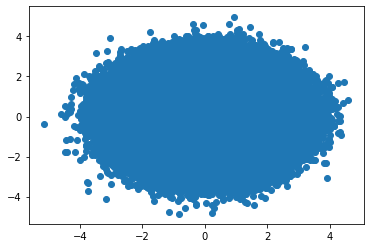